In [1]:
import numpy as np
import pandas as pd
import csv
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from pandas.plotting import scatter_matrix
from matplotlib import cm
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
from numpy import inf
from sklearn.metrics.pairwise import cosine_similarity
import umap
import networkx as nx
import json
import pyreadr
import obonet
import scipy.stats as stats
import networkx as nx
from sklearn.preprocessing import Normalizer
import seaborn as sns
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Latex
%matplotlib inline

sphinx:
  config:
    mathjax_path: https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js

# AIM:

**The Goal of the project is to develop an algorithm that can prioritize causal genes for a set of given HPO times using CKG graph database**


## Inputs

*Neo4J was used to create the gene and phenotype embedding using the algorithm fastrp.
The gene and phenotype was saved in the feather format.
the hyperparameter of 0.75 was used to weight highly connected edges
unconnected genes were filtered out**

We have two sets of IC
1. Mayo cohort IC 
2. PCAN IC 

*We 276 solved cases to test and train the method


### Normalizing the PCAN IC's into probabilites

In [75]:
PCAN_IC_df = pd.read_csv("/research/bsi/projects/staff_analysis/m109297/PI_support/PCAN/PCAN_wrapper_dev/HPO_IC.csv")
PCAN_IC_values = [ float(x) for x in list(PCAN_IC_df.IC.values) if np.isnan(x) == False]
PCAN_IC_sort = sorted(PCAN_IC_values)
MIN_PCAN_IC = PCAN_IC_sort[1]
PCAN_IC_df['IC'] = PCAN_IC_df['IC'].fillna(MIN_PCAN_IC)
PCAN_IC_df['IC'] = PCAN_IC_df['IC'].replace({0:MIN_PCAN_IC})

scaler = MinMaxScaler()
PCAN_IC_df['PROBABILITIES'] = scaler.fit_transform(PCAN_IC_df['IC'].values.reshape(-1,1))
PCAN_IC_new_df = PCAN_IC_df[['id', 'PROBABILITIES']]
PCAN_IC_new_df.columns = ['HPO', 'PROBABILITIES']
PCAN_IC_new_df['PROBABILITIES'] = PCAN_IC_new_df['PROBABILITIES'].replace({0:0.0005412991539235149})
PCAN_IC_new_df.to_csv("../data//PCAN_IC_normalized.csv", index=False)
l1_nb_df = pd.read_csv('../data/training/L1_nb_prob.csv')



Phenotype,HP:0000002,HP:0000003,HP:0000006,HP:0000007,HP:0000008,HP:0000009,HP:0000010,HP:0000011,HP:0000012,HP:0000013,...,HP:0500270,HP:0550004,HP:3000005,HP:3000010,HP:3000019,HP:3000037,HP:3000038,HP:3000050,HP:3000052,HP:3000062
Gene,,,,,,,,,,,,,,,,,,,,,
A2ML1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A4GALT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAAS,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAGAB,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AARS1,NaN,NaN,0.999994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZP1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZP2,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,7.175597e-13,NaN,NaN,NaN,NaN
ZP3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Algorithm

The following code below is the algorithm for 4 different models
1. DP (Dot product with SoftMax)
2. CD (Cosine Similarity)
3. SD (Dot product without SoftMax)
4. Bayesian 






## Information Content

$$ IC_x = -\log_{2}(p\vec(x)) $$


## Dot product

$$\vec{Z} = a_1^Tb_1 + a_2^Tb_2 + ...... + a_n^Tb_n$$

$$ \vec{a} = \sigma(z) = \frac{e^{z_i - Max(z)_i}}{\sum_{j=1}^{n}} $$

$$ \vec{h} = IC_x * \vec{a} $$

$$ Rank = \max(\sum_{i=1}^{j=n}{\vec{h}})$$




## Cosine Similarity

$$cosine \ similarity \ \vec{Z} = \frac{a^Tb}{|a|.|b|} $$

$$ \vec{a} = \sigma(z) = \frac{e^{z_i - Max(z)_i}}{\sum_{j=1}^{n}} $$

$$ \vec{h} = IC_x * \vec{a} $$

$$ Rank = \max(\sum_{i=1}^{j=n}{\vec{h}})$$


## Bayesian approach



$$ \vec{Z} = a_1^Tb_1 + a_2^Tb_2 + ...... + a_n^Tb_n$$

$$ \vec{a} = \sigma(z) = \frac{e^{z_i - Max(z)_i}}{\sum_{j=1}^{n}} $$

$$ \vec{h} = -\log_2(\frac{a}{IC_x}) $$

$$ Rank = \max(\vec{h})$$



In [149]:
probability_table_mayo_df = pd.read_csv("../data/training/probabilities.csv")
probability_table_PCAN_df = pd.read_csv("../data/training/PCAN_IC_normalized.csv")
#probability_table_df['Probability'] = minmax_scale(probability_table_df['IC'])
#ckg_gene_count_df = pd.read_csv("../../data/CKG/CKG_genes_connected_counts.tsv", sep="\t")
ckg_hpo_count_df = pd.read_csv("/research/bsi/projects/PI/tertiary/Klee_Eric_mrl2075/s212354.RadiaNT/MultiomicsSummaries/data/CKG/CKG_HPO_connected_counts.tsv", sep="\t")
clinvar_genes_total = 3564
ckg_hpo_count_df.columns = ['index', 'count', 'HPO']
ckg_hpo_count_df['PROBABILITIES'] = ckg_hpo_count_df['count']/clinvar_genes_total
probability_ckg_df = ckg_hpo_count_df[["HPO", "PROBABILITIES"]]

phenotype_df = pd.read_feather("/research/bsi/projects/PI/tertiary/Klee_Eric_mrl2075/s212354.RadiaNT/MultiomicsSummaries/data/CKG/param_0_2/Phenotype.ftr")
gene_df = pd.read_feather("/research/bsi/projects/PI/tertiary/Klee_Eric_mrl2075/s212354.RadiaNT/MultiomicsSummaries/data/CKG/param_0_2//Gene.ftr")
test_df = pd.read_csv("/research/bsi/projects/PI/tertiary/Klee_Eric_mrl2075/s212354.RadiaNT/MultiomicsSummaries/Rohan/data/HPO_Gene_solves_filtered_withHP.test.txtd", delimiter='\t')
test_gdf = pd.read_csv("/research/bsi/projects/PI/tertiary/Klee_Eric_mrl2075/s212354.RadiaNT/MultiomicsSummaries/Rohan/data/HPO_Gene_solves_filtered_withHP.test.txtd", delimiter='\t')
solved_df= pd.read_csv("/research/bsi/projects/PI/tertiary/Klee_Eric_mrl2075/s212354.RadiaNT/MultiomicsSummaries/Rohan/src/solved_cases.csv")
filter_gene_df =pd.read_csv("/research/bsi/projects/PI/tertiary/Klee_Eric_mrl2075/s212354.RadiaNT/MultiomicsSummaries/data/CKG/withNewEdgesGenePhenoDisease/version2/GenesWithEdges.csv")
colum_name_dict = { 'ID(n)':'ID', 
              'labels(n)':'labels', 
              'n.`fastrp-embedding`':'fastrp_embedding', 
              'n.description':'description',
              'n.id':'id', 
              'n.name':'name', 
              'n.synonyms':'synonyms', 
              'n.type':'type'}
hpo_url = 'http://purl.obolibrary.org/obo/hp.obo'
phenotype_new_df = phenotype_df.rename(columns=colum_name_dict)
gene_new_df = gene_df.rename(columns=colum_name_dict)
test_solved_df = pd.merge(solved_df, test_df, on=['Original ID'], how='left')
HPO_terms_set = set(phenotype_new_df['id'].tolist())
gene_list_df = pd.read_csv("/research/bsi/projects/PI/tertiary/Klee_Eric_mrl2075/s212354.RadiaNT/MultiomicsSummaries/Rohan/src/clinvarGenes.txt")
gene_list = gene_list_df['CLINVAR_GENES'].tolist()
gene_new_clinvar_df = gene_new_df[gene_new_df['id'].isin(gene_list)].reset_index(drop=True)


filter_gene_list = list(set(filter_gene_df['n.id'].tolist()))
old_method_df = pd.read_csv("/research/bsi/projects/PI/tertiary/Klee_Eric_mrl2075/s212354.RadiaNT/MultiomicsSummaries/Kowshika/Data/KS/ClinVar-Genes-1-Based/comparison.csv")
PCAN_df = old_method_df[['case_id', 'Rank_PCAN']]
PCAN_df.columns = ['Normalized ID', 'Rank_PCAN']

#print(len(gene_list))
linked_genes = list(set(l1_nb_df.Gene.to_list()))
print(len(set(linked_genes) - set(gene_list)))
genes_to_keep = (set(gene_list) & set(linked_genes))
phenotypes_to_keep = probability_ckg_df.HPO.tolist()
print(len(genes_to_keep))
gene_new_clinvar_df = gene_new_clinvar_df[gene_new_clinvar_df['id'].isin(genes_to_keep)]
gene_new_clinvar_df = gene_new_clinvar_df.reset_index(drop=True)

l1_nb_gene_df = l1_nb_df[l1_nb_df['Gene'].isin(genes_to_keep)]
l1_nb_wide_df = l1_nb_gene_df.pivot_table(index='Gene', columns='Phenotype', values='probabilities')
l1_nb_wide_df = l1_nb_wide_df.fillna(0.01)

#phenotype_new_df = phenotype_new_df[phenotype_new_df['id'].isin(phenotypes_to_keep)]
phenotype_new_df

1284
3469


,ID,labels,fastrp_embedding,description,id,name,synonyms,type
0,62653,[Phenotype],"[0.03413129225373268, -0.016045013442635536, -...",All,HP:0000001,All,"[All, UMLS:C0444868]",-44
1,62654,[Phenotype],"[-0.11156182736158371, -0.030946122482419014, ...",Deviation from the norm of height with respect...,HP:0000002,Abnormality of body height,"[Abnormality of body height, Abnormality of bo...",-44
2,62655,[Phenotype],"[-0.18007054924964905, 0.10856611281633377, 0....",Multicystic dysplasia of the kidney is charact...,HP:0000003,Multicystic kidney dysplasia,"[Multicystic kidney dysplasia, Multicystic dys...",-44
3,62656,[Phenotype],"[-0.09929313510656357, -0.03730218857526779, -...",The pattern in which a particular genetic trai...,HP:0000005,Mode of inheritance,"[Mode of inheritance, Inheritance, UMLS:C1708511]",-44
4,62657,[Phenotype],"[-0.059611234813928604, 0.040600426495075226, ...",A mode of inheritance that is observed for tra...,HP:0000006,Autosomal dominant inheritance,"[Autosomal dominant inheritance, Autosomal dom...",-44
...,...,...,...,...,...,...,...,...
15867,78520,[Phenotype],"[0.08135274797677994, 0.03305444493889809, 0.1...",Any structural anomaly of a lingual nerve. [GO...,HP:3000075,Abnormal lingual nerve morphology,"[Abnormal lingual nerve morphology, Abnormalit...",-44
15868,78521,[Phenotype],"[-0.01535889320075512, 0.04589907079935074, 0....",An abnormality of a lingual tonsil. [GOC:TermG...,HP:3000076,Abnormality of lingual tonsil,"[Abnormality of lingual tonsil, UMLS:C4073283]",-44
15869,78522,[Phenotype],"[0.12586821615695953, 0.006285094656050205, 0....",An abnormality of a mandible condylar process....,HP:3000077,Abnormal mandible condylar process morphology,[Abnormal mandible condylar process morphology...,-44
15870,78523,[Phenotype],"[0.0970887690782547, 0.013445338234305382, -0....",An abnormality of a mandible coronoid process....,HP:3000078,Abnormal mandible coronoid process morphology,[Abnormal mandible coronoid process morphology...,-44


In [134]:
class RankQuery(object):
    
    def __init__(self, df1, df2, prob_df, filter_list):
        self.df1 = df1
        self.df2 = df2
        self.filter_list = filter_list
        self.prob_df = prob_df
    
    def __iter__(self):
        return self
    
    def embeddings1(self):
        return self.df1.fastrp_embedding.values
    
    def embeddings2(self):
        return self.df2.fastrp_embedding.values
    
    def dot_product(self):
        df1_embedding = self.embeddings1()
        df2_embedding = self.embeddings2()
        x = np.matmul(df1_embedding.tolist(), 
                         np.transpose(df2_embedding.tolist())) #shape(15872, 3564)
        #x = preprocessing.normalize(x, norm='l2',axis=0)
        #Data_normalized = Data_normalizer.transform(x)
        return x
        
    def cosine_similarity(self):
        df1_embedding = np.array(self.embeddings1().tolist())
        df2_embedding = np.array(self.embeddings2().tolist())
        x = cosine_similarity(df1_embedding, df2_embedding)  #shape(15872, 3564)
        #print(x.shape) 
        return x
      
    def get_probability(self):
        #probability_table_df = pd.read_csv("../src/probabilities.csv")
        #probability_table_df = pd.read_csv("../src/PCAN_IC_normalized.csv")
        #probability_table_df = pd.read_csv("/research/bsi/projects/staff_analysis/m109297/PI_support/PCAN/PCAN_wrapper_dev/HPO_IC.csv")
        #probability = probability_table_df.query['HPO'== self.query]['PROBABILITIES']
        try:
            #probability = probability_table_df[probability_table_df['id']==self.query]['IC'].values[0]
            probability = self.prob_df[self.prob_df['HPO']==self.query]['PROBABILITIES'].values[0]
            return probability
        except IndexError:
            print("HPO {0} not found in the list of probabilities".format(self.query))
            #return min(probability_table_df['IC'])
            #print(min(probability_table_df['PROBABILITIES']))
            #return max(self.prob_df['PROBABILITIES'])
            #return 1
            return min(self.prob_df['PROBABILITIES'])
            #exit()
    
    def log_probability(self):
        try:
            probability = self.get_probability()
            log_probs =  -math.log2(probability) 
            return log_probs
        except TypeError:
            print("HPO {0} not found in the list of probabilities".format(self.query))
            exit()
    
    
    #def get_information_content(self):
    #    log_prob = self.log_probability()
    #    IC = log_prob * np.transpose(np.array(self.embeddings2().tolist()))
    #    return np.matmul(np.array(self.embeddings1().tolist()), IC)
    
    def get_IC_result(self):
        self.index = self.df1.index[self.df1['id'] == self.query]
        get_row_IC = self.get_information_content()[self.index,:]
        return get_row_IC[0]
    
    def get_suprise(self):
        probability = self.get_probability(self.query)
        suprise = probability * np.array(self.embeddings2().tolist())
        return suprise
    
    def get_suprise_result(self):
        self.index = self.df1.index[self.df1['id'] == self.query]
        get_row_suprise = self.get_suprise()[self.index,:]
        return get_row_suprise[0]
    
    def get_dp_result(self):
        try:
            self.index = self.df1.index[self.df1['id'] == self.query]
            get_row_dp = self.dot_product()[self.index,:]
        #get_row_cs = self.dot_product()[self.index,:]
            return get_row_dp[0]#,get_row_cs[0]
        except IndexError:
            return None
            print("{0} not found in phenotype df".format(self.query))
    
    def stable_softmax(self):
        if self.get_dp_result() is not None:
            x = self.get_dp_result()
            #print(x)
            z = x - max(x)
            numerator = np.exp(z)
            denominator = np.sum(numerator)
            softmax = numerator/denominator
            return softmax
        else:
            return 0

    
    def get_cosine_result(self):
        try:
            self.index = self.df1.index[self.df1['id'] == self.query]
            get_cosine = self.cosine_similarity()[self.index,:] * self.log_probability()
            #get_row_cs = self.dot_product()[self.index,:]
            return get_cosine[0]#,get_row_cs[0
        except IndexError:
            print("{0} not found in phenotype df".format(self.query))
            return 0
    
    #def get_geometric_mean(self):
        
    
    def show_dp_results_sm(self, *query):
        count = 0
        dot_pdt_arr = []
        dot_pdt_sm_arr = []
        for new_query in query:
            count += 1
            self.query = new_query
            dot_pdt_sm = self.stable_softmax()
            dot_pdt_sm_arr.append(dot_pdt_sm)
            dot_pdt_IC = dot_pdt_sm * self.log_probability()
            #print(dot_pdt_IC)
            dot_pdt_arr.append(dot_pdt_IC)
        #print(dot_pdt_arr)
        dot_pdt_sm_arr_sum = sum(dot_pdt_sm_arr)
        #print(sum(dot_pdt_arr))
        self.df2['results_dp'] = sum(dot_pdt_arr)
        sort_df = self.df2.sort_values('results_dp', ascending=False)
        sort_df["gw"] = np.where(sort_df['id'].isin(self.filter_list), True, False)
        sort_df.loc[(sort_df['gw'] == False), 'results_dp_new'] = float(-inf)
        sort_df.loc[(sort_df['gw'] == True), 'results_dp_new'] = sort_df['results_dp']
        sort_df = sort_df.sort_values('results_dp_new', ascending=False)
        sort_df = sort_df.reset_index(drop=True)
        return(sort_df)
    
    def show_dp_results_nosm(self, *query):
        count = 0
        dot_pdt_arr = []
        dot_pdt_sm_arr = []
        for new_query in query:
            count += 1
            self.query = new_query
            try:
                dot_pdt_IC = self.get_dp_result() * self.log_probability()
                dot_pdt_arr.append(dot_pdt_IC)
            except TypeError:
                print("{0} is getting a type error for dot product".format(new_query))
                pass
        dot_pdt_sm_arr_sum = sum(dot_pdt_sm_arr)
        self.df2['results_dp'] = sum(dot_pdt_arr)
        sort_df = self.df2.sort_values('results_dp', ascending=False)
        sort_df["gw"] = np.where(sort_df['id'].isin(self.filter_list), True, False)
        sort_df.loc[(sort_df['gw'] == False), 'results_dp_new'] = float(-inf)
        sort_df.loc[(sort_df['gw'] == True), 'results_dp_new'] = sort_df['results_dp']
        sort_df = sort_df.sort_values('results_dp_new', ascending=False)
        sort_df = sort_df.reset_index(drop=True)
        return(sort_df)
    
    def show_cosine_results(self, *query):
        cosine_arr = []
        for new_query in query:
            self.query = new_query
            cosine_arr.append(self.get_cosine_result())
        self.df2['results_cosine'] = sum(cosine_arr)
        sort_df = self.df2.sort_values('results_cosine', ascending=False)
        sort_df["gw"] = np.where(sort_df['id'].isin(self.filter_list), True, False)
        sort_df.loc[(sort_df['gw'] == False), 'results_cosine_new'] = float(-inf)
        sort_df.loc[(sort_df['gw'] == True), 'results_cosine_new'] = sort_df['results_cosine']
        sort_df = sort_df.sort_values('results_cosine_new', ascending=False)
        sort_df = sort_df.reset_index(drop=True)
        return(sort_df)
    
    def show_IC_results(self, *query):
        IC_arr = []
        for new_query in query:
            self.query = new_query
            IC_arr.append(self.get_IC_result())
        IC_results = sum(IC_arr)
        self.df2['IC_results'] = IC_results
        return(self.df2.sort_values('IC_results', ascending=False))


In [153]:

class dot_product(object):
    
    def __init__(self, phenotype_df, gene_df, prob_df):
        self.phenotype_df = phenotype_df # phenotype (hpo id and fastrp embedding)
        self.gene_df = gene_df # gene (gene id and fastrp embedding)
        self.prob_df = prob_df
        
    def inndot_product(self):
        df1_embedding = self.gene_df.fastrp_embedding.values
        df2_embedding = self.phenotype_df.fastrp_embedding.values #shape(15872, 3564)
        x = np.matmul(df1_embedding.tolist(), 
                         np.transpose(df2_embedding.tolist())) 
        return x
    
    @staticmethod
    def stable_softmax(x):
        z = x - np.max(x,axis=1)[:,np.newaxis]
        numerator = np.exp(z)
        denominator = np.sum(numerator,axis=1)
        softmax = numerator/denominator[:,np.newaxis]
        return softmax
    
    def execute_softmax(self):
        #print(np.shape(self.inndot_product()))
        softmax = dot_product.stable_softmax(self.inndot_product())
        return softmax
    
    def log_probability(self):
        try:
            probability = self.get_probability()
            log_probs =  -math.log2(probability) 
            return log_probs
        except TypeError:
            print("HPO {0} not found in the list of probabilities".format(self.query))
            exit()
    
    def create_dataframe(self):
        prob_table_df = self.prob_df.set_index('HPO')
        rownames = self.gene_df.id
        columns_df = self.phenotype_df.id.to_frame().set_index('id')
        columns_order = self.phenotype_df.id.to_frame()
        columns_df = columns_df.join(prob_table_df)
        #columns_df = columns_df.fillna(np.nanmin(columns_df.to_numpy()))
        columns_df = columns_df.fillna(0.001)
        columns_df = columns_df.reindex(columns_order.id)
        value = self.execute_softmax() * columns_df.to_numpy().T
        final_value = np.log(value)
        final_df = pd.DataFrame(data=final_value, index = rownames, columns=columns_order.id)
        return final_df

class BayesRank(object):
    
    def __init__(self, phenotype_df, gene_df, prob_df):
        self.phenotype_df = phenotype_df # phenotype (hpo id and fastrp embedding)
        self.gene_df = gene_df # gene (gene id and fastrp embedding)
        self.prob_df = prob_df # probability (hpo_id and hpo_prob)
        #self.filter_df = filter_df
        #self.hpo_set = set(hpo_df.hpo_id.values)
        #self.gene_set = set(gene_df.gene_id.values)

    def inndot_product(self):
        df1_embedding = self.gene_df.fastrp_embedding.values
        df2_embedding = self.phenotype_df.fastrp_embedding.values #shape(15872, 3564)
        x = np.matmul(df1_embedding.tolist(), 
                         np.transpose(df2_embedding.tolist()))
        #x = preprocessing.normalize(x, norm='l2',axis=0)
        #Data_normalized = Data_normalizer.transform(array)
        return x
    
    @staticmethod
    def stable_softmax(x):
        z = x - np.max(x,axis=1)[:,np.newaxis]
        numerator = np.exp(z)
        denominator = np.sum(numerator,axis=1)
        softmax = numerator/denominator[:,np.newaxis]
        return softmax
    
    def execute_softmax(self):
        #print(np.shape(self.inndot_product()))
        softmax = BayesRank.stable_softmax(self.inndot_product())
        return softmax
    
    def create_dataframe(self):
        prob_table_df = self.prob_df.set_index('HPO')
        rownames = self.gene_df.id
        columns_order = self.phenotype_df.id.to_frame()
        columns_df = self.phenotype_df.id.to_frame().set_index('id')
        columns_df = columns_df.join(prob_table_df)
        columns_df = columns_df.fillna(0.001)
        #columns_df = columns_df.fillna(np.nanmin(columns_df.to_numpy()))
        columns_df = columns_df.reindex(columns_order.id)
        finalmat = np.log(self.execute_softmax()/columns_df.to_numpy().T)
        final_df = pd.DataFrame(data=finalmat, index = rownames, columns=columns_order.id)
        return final_df
    
dp_model = dot_product(phenotype_new_df, gene_new_clinvar_df, probability_ckg_df)
test = dp_model.create_dataframe()
test

id,HP:0000001,HP:0000002,HP:0000003,HP:0000005,HP:0000006,HP:0000007,HP:0000008,HP:0000009,HP:0000010,HP:0000011,...,HP:3000070,HP:3000071,HP:3000072,HP:3000073,HP:3000074,HP:3000075,HP:3000076,HP:3000077,HP:3000078,HP:3000079
id,,,,,,,,,,,,,,,,,,,,,
SERPINB8,-16.293481,-15.062817,-13.826405,-17.074160,-10.276872,-10.127893,-13.897393,-16.218718,-12.995005,-14.405481,...,-17.190345,-17.190345,-16.131823,-16.026702,-16.561541,-15.573637,-16.429364,-16.388186,-16.551340,-16.280261
GMNN,-17.230805,-14.542309,-11.759679,-16.303181,-8.650403,-7.849372,-12.362175,-16.182224,-11.702244,-13.547763,...,-17.440655,-17.440655,-17.071074,-17.750597,-17.157337,-17.224246,-16.830096,-17.695183,-17.722667,-17.153454
RTN2,-17.168898,-15.289922,-12.702511,-16.963679,-10.215763,-9.555561,-13.459714,-15.705510,-12.578850,-14.239145,...,-17.238173,-17.238173,-17.092923,-16.888475,-16.574567,-17.189546,-16.663204,-16.506174,-16.746642,-16.827116
CHRNB1,-16.881052,-14.863824,-12.637356,-17.286260,-9.768581,-8.828979,-13.365796,-16.309991,-12.280932,-14.458181,...,-17.142228,-17.142228,-16.506683,-17.447520,-16.549063,-16.512615,-17.647467,-17.354772,-17.109087,-16.852797
SLC30A2,-17.385403,-14.458359,-13.306221,-16.480015,-10.001632,-9.610887,-13.630726,-15.779409,-12.315701,-14.265108,...,-16.179465,-16.179465,-16.575349,-17.517864,-16.595764,-17.304649,-15.736610,-17.004484,-16.935817,-16.616392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SGCD,-16.199574,-15.315225,-12.298582,-16.528306,-9.383267,-9.054982,-13.792500,-15.504326,-12.538662,-13.135028,...,-17.039793,-17.039793,-16.695815,-17.226950,-16.828156,-17.200910,-16.968483,-16.368319,-16.427132,-16.504154
HNRNPH2,-17.164445,-14.513472,-12.468041,-15.997170,-8.944563,-8.985517,-12.943587,-15.361498,-11.788938,-13.825431,...,-17.212383,-17.212383,-17.400500,-18.171762,-17.918205,-16.520280,-17.479935,-17.005523,-17.051796,-16.770183
REEP1,-16.904869,-15.335329,-12.388560,-16.895263,-9.780314,-9.654140,-14.017897,-15.375615,-12.779080,-13.556398,...,-17.206820,-17.206820,-17.105742,-17.033478,-16.535955,-16.525616,-16.366902,-16.967170,-17.269525,-16.747993


## Here is where the inputs are read

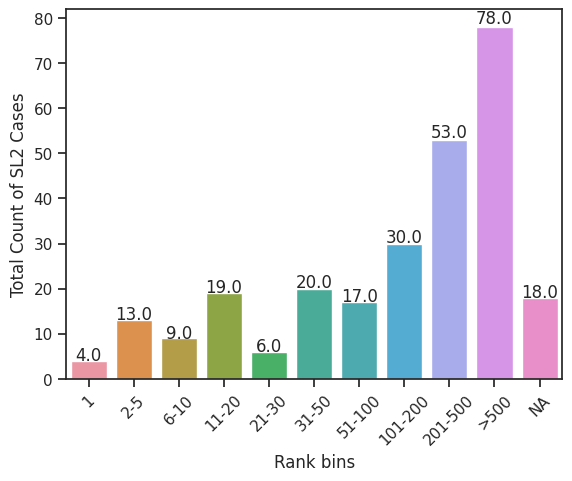

In [97]:
from collections import Counter

def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

def plot_top(some_array, method):
    bins = [1,'2-5','6-10','11-20','21-30','31-50','51-100','101-200','201-500','>500']
    counter = Counter(bins)
    for i in some_array:
        if i == 1:
            counter[1] +=1
        elif i>1 and i<=5:
            counter["2-5"] +=1
        elif i>5 and i<=10:
            counter["6-10"] +=1
        elif i>10 and i<=20:
            counter['11-20'] +=1
        elif i>20 and i<=30:
            counter['21-30'] +=1
        elif i>30 and i<=50:
            counter['31-50'] +=1
        elif i>50 and i<=100:
            counter['51-100'] +=1
        elif i>100 and i<=200:
            counter['101-200'] +=1
        elif np.isnan(i):
            counter['NA'] +=1
        elif i>200 and i<=500:
            counter['201-500'] +=1
        else:
            counter['>500'] +=1
    counter_df = pd.DataFrame.from_dict(counter, orient='index')
    counter_df = counter_df.reset_index()
    counter_df.columns = ['bins','SL2_counts']
    counter_df['Percentage'] = round(counter_df['SL2_counts']/sum(counter_df['SL2_counts']),2) * 100 + 0.01
    counter_df['Algorithm'] = method
    keys = list(counter.keys())
    vals = [counter[k]-1 for k in keys]
    x = sns.barplot(x=keys, y=vals)
    x.set(xlabel='Rank bins', ylabel='Total Count of SL2 Cases')
    plt.xticks(rotation=45)
    return show_values(x),counter_df

PCAN_plot, PCAN_count = plot_top(old_method_df.Rank_PCAN.values, "PCAN")


In [98]:
PCAN_count

,bins,SL2_counts,Percentage,Algorithm
0,1,5,2.01,PCAN
1,2-5,14,5.01,PCAN
2,6-10,10,4.01,PCAN
3,11-20,20,7.01,PCAN
4,21-30,7,3.01,PCAN
5,31-50,21,8.01,PCAN
6,51-100,18,6.01,PCAN
7,101-200,31,11.01,PCAN
8,201-500,54,19.01,PCAN
9,>500,79,28.01,PCAN


### The absolute test was a deadend, there was a massive loss in information and the ranks were a lot poorer than not doing the absolute

In [99]:
## Tetsting distribution of dot product with softMax

def stable_softmax(x):
        z = x - np.max(x,axis=1)[:,np.newaxis]
        numerator = np.exp(z)
        denominator = np.sum(numerator,axis=1)
        softmax = numerator/denominator[:,np.newaxis]
        #print(sum(softmax))
        return softmax
#print(test_dp_all.shape)
#np.max(test_dp_all, axis=1)[:,np.newaxis]
#print(sf_test)
#sf_test = stable_softmax(test_dp_all)
#print(sf_test.shape)
#sf_test_df = pd.DataFrame(sf_test)

#sf_test_df = sf_test_df.transpose()
#sf_test_df.columns = exostoses_genes
#sf_test_melt_df = sf_test_df.melt()
#sns.displot(sf_test_melt_df, x='value', hue='variable',kind="kde")



In [100]:
x = gene_new_df.fastrp_embedding.values.tolist()
x
#y = np.transpose(phenotype_new_df.fastrp_embedding.values.tolist())
#xy = np.matmul(x,y)

tsne = TSNE(random_state = 0, n_iter = 500, metric = 'cosine')
embeddings2d = tsne.fit_transform(x)
gene_columns = gene_new_df['id'].tolist()
gene_tsne_df = pd.DataFrame(x)

#DP_df['gene'] = gene_new_clinvar_df['id']
#tsne_df = pd.DataFrame(embeddings2d, columns=['TSNE1', 'TSNE2'])

#tsne_df['gene'] = gene_new_df['id']
#tsne_df['group'] = np.where(tsne_df['TSNE1'])



#fig = px.scatter(
#    tsne_new_df, x='TSNE1', y='TSNE2', hover_data=['gene'])
#fig.show()


<AxesSubplot:xlabel='TSNE1', ylabel='TSNE2'>

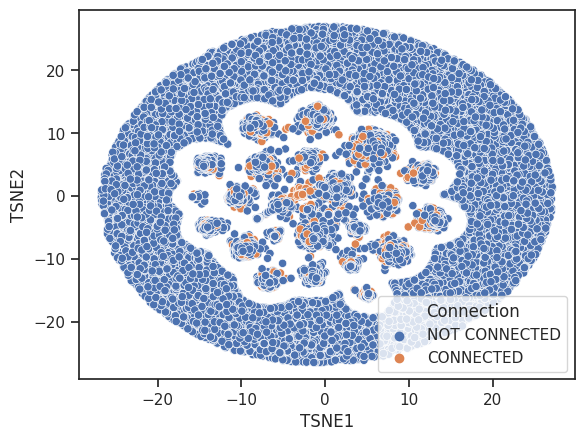

In [101]:
#genes_to_keep =f['n.id'].tolist()
tsne_gene_df = pd.DataFrame(embeddings2d, columns=['TSNE1', 'TSNE2'])
tsne_gene_df['gene'] = gene_new_df.id
tsne_gene_df['Connection'] = np.where(tsne_gene_df['gene'].isin(genes_to_keep), "CONNECTED", "NOT CONNECTED")


sns.scatterplot(x="TSNE1", y='TSNE2', hue="Connection", data=tsne_gene_df)

## Code to apply and view results from the algorithms

In [162]:

def prune_hp(df,HPO_list):
    cols_to_drop = []
    for i in HPO_list:
        mean = df[i].mean()
        if mean > -4:
            cols_to_drop.append(i)
    return cols_to_drop

def check_hp(df,HPO_list, gene, prob_df):
    metric_list = []
    for i in HPO_list:
        mean = df[i].mean()
        sd = df[i].std()
        z_score = stats.zscore(df[i].tolist())
        median = df[i].median()
        new_df =  pd.DataFrame(df[i].sort_values(ascending=False))
        new_df = new_df.reset_index()
        prob = list(prob_df[prob_df['HPO'] == i]['PROBABILITIES'])[0]
        rank = new_df.index[new_df['id'] == gene].tolist()[0] +1
        metric_list.append((i, gene, mean, sd, median, rank, prob))
    x = pd.DataFrame(metric_list, columns=('HPO', 'GENE', 'Mean', 'Std', "Median", 'Rank', 'Probability'))
    return x
                     
        
def run_methods(df, bayes_df, model_df, prob_df, l1_nb_wide_df):
    for i, j in df.iterrows():
        HPO_list = j['HPO'].strip().split(",")
        total_count = len(HPO_list)
        gene = df['Gene1'][i]
        filter_HPO = list(set(HPO_list).intersection(phenotype_new_df.id.tolist()))
        #metrics_df = check_hp(bayes_df, filter_HPO, gene, prob_df)
        bm_all_df = pd.DataFrame(bayes_df[filter_HPO])
        link_df = l1_nb_wide_df[filter_HPO]
        link_df = link_df.reindex(index=bm_all_df.index)
        print(bm_all_df)
        print(link_df)
        bm_df = pd.DataFrame(bayes_df[filter_HPO].max(axis=1).sort_values(ascending=False))
        bm_mean_df = pd.DataFrame(bayes_df[filter_HPO].mean(axis=1).apply(lambda x: x/len(filter_HPO)).sort_values(ascending=False)).reset_index()
        #bm_geo_df = pd.DataFrame(bayes_df[filter_HPO].prod(axis=1).apply(lambda x: x/len(filter_HPO)).sort_values(ascending=False)).reset_index()
        #fig = plt.figure(figsize=(10,6))
        #for col in filter_HPO:
        bm_all_melt_df =bm_all_df.melt()
        #sns.displot(bm_all_melt_df, x='value', hue='id')
        #fig.legend(labels=[filter_HPO])
        ld = model_df.show_dp_results_sm(*filter_HPO)
        print(ld)
        bm_df = bm_df.reset_index()
        cd = model_df.show_cosine_results(*filter_HPO)
        sd = model_df.show_dp_results_nosm(*filter_HPO)
        rank_bayes = bm_df.index[bm_df['id'] == df['Gene1'][i]].tolist()
        rank_bayes = [i +1 for i in rank_bayes]
        rank_dp = ld.index[ld['id'] == df['Gene1'][i]].tolist()
        rank_dp = [i +1 for i in rank_dp]
        rank_cd = cd.index[cd['id'] == df['Gene1'][i]].tolist()
        rank_cd = [i +1 for i in rank_cd]
        rank_sd = sd.index[cd['id'] == df['Gene1'][i]].tolist()
        rank_sd = [i +1 for i in rank_sd]
        rank_bayes_mean = bm_mean_df.index[bm_mean_df['id'] == df['Gene1'][i]].tolist()
        rank_bayes_mean = [i +1 for i in rank_bayes_mean]
        #rank_bayes_geo = bm_geo_df.index[bm_geo_df['id'] == df['Gene1'][i]].tolist()
        #rank_bayes_geo = [i +1 for i in rank_bayes_geo]
        try:
            df.loc[df.index[i],'DOT_PRODUCT'] = rank_dp
            df.loc[df.index[i],'COSINE'] = rank_cd
            df.loc[df.index[i],'Rank_sd'] = rank_sd
            df.loc[df.index[i],'Rank_bayes'] = rank_bayes
            df.loc[df.index[i],'BAYES'] = rank_bayes_mean
            #df.loc[df.index[i],'rank_bayes_geo'] = rank_bayes_geo
        except ValueError:
            df.loc[df.index[i],'DOT_PRODUCT'] = -1
            df.loc[df.index[i],'COSINE'] = -1
            df.loc[df.index[i],'Rank_sd'] = -1
            df.loc[df.index[i],'Rank_bayes'] = -1
            df.loc[df.index[i],'BAYES'] = -1
            #df.loc[df.index[i],'rank_bayes_geo'] = -1
    return df


def run_methods_new(df, bayes_df, dp_df, l1_nb_wide_df):
    for i, j in df.iterrows():
        HPO_list = j['HPO'].strip().split(",")
        total_count = len(HPO_list)
        gene = df['Gene1'][i]
        filter_HPO = list(set(HPO_list).intersection(phenotype_new_df.id.tolist()))
        #metrics_df = check_hp(bayes_df, filter_HPO, gene, prob_df)
        bm_all_df = pd.DataFrame(bayes_df[filter_HPO])
        #link_df = l1_nb_wide_df[filter_HPO]
        #link_df = link_df.reindex(index=bm_all_df.index)
        bm_df = pd.DataFrame(bayes_df[filter_HPO].max(axis=1).sort_values(ascending=False))
        bm_mean_df = pd.DataFrame(bayes_df[filter_HPO].mean(axis=1).apply(lambda x: x/len(filter_HPO)).sort_values(ascending=False)).reset_index()
        bm_all_melt_df =bm_all_df.melt()
        dpm_all_df = pd.DataFrame(dp_df[filter_HPO])
        dpm_df = dp_df.reset_index()
        dpm_df = pd.DataFrame(dp_df[filter_HPO].max(axis=1).sort_values(ascending=False))
        dpm_mean_df = pd.DataFrame(dp_df[filter_HPO].mean(axis=1).apply(lambda x: x/len(filter_HPO)).sort_values(ascending=False)).reset_index()
        dpm_mean_melt_df =dpm_all_df.melt()
        bm_df = bm_df.reset_index()
        dpm_df = dpm_df.reset_index()
        #cd = model_df.show_cosine_results(*filter_HPO)
        #sd = model_df.show_dp_results_nosm(*filter_HPO)
        rank_bayes = bm_df.index[bm_df['id'] == df['Gene1'][i]].tolist()
        rank_bayes = [i +1 for i in rank_bayes]
        rank_dp = dpm_df.index[dpm_df['id'] == df['Gene1'][i]].tolist()
        rank_dp = [i +1 for i in rank_bayes]
        #rank_dp = ld.index[ld['id'] == df['Gene1'][i]].tolist()
        #rank_dp = [i +1 for i in rank_dp]
        #rank_cd = cd.index[cd['id'] == df['Gene1'][i]].tolist()
        #rank_cd = [i +1 for i in rank_cd]
        #rank_sd = sd.index[cd['id'] == df['Gene1'][i]].tolist()
        #rank_sd = [i +1 for i in rank_sd]
        rank_bayes_mean = bm_mean_df.index[bm_mean_df['id'] == df['Gene1'][i]].tolist()
        rank_bayes_mean = [i +1 for i in rank_bayes_mean]
        rank_dp_mean = dpm_mean_df.index[dpm_mean_df['id'] == df['Gene1'][i]].tolist()
        rank_dp_mean = [i +1 for i in rank_dp_mean]
        try:
            df.loc[df.index[i],'DOT_PRODUCT'] = rank_dp
            df.loc[df.index[i],'DOT_PRODUCT_mean'] = rank_dp_mean
        #    df.loc[df.index[i],'COSINE'] = rank_cd
        #    df.loc[df.index[i],'Rank_sd'] = rank_sd
            df.loc[df.index[i],'Rank_bayes'] = rank_bayes
            df.loc[df.index[i],'BAYES_mean'] = rank_bayes_mean
        except ValueError:
            df.loc[df.index[i],'DOT_PRODUCT'] = -1
            df.loc[df.index[i],'DOT_PRODUCT_mean'] = -1
        #    df.loc[df.index[i],'COSINE'] = -1
        #    df.loc[df.index[i],'Rank_sd'] = -1
            df.loc[df.index[i],'Rank_bayes'] = -1
            df.loc[df.index[i],'BAYES_mean'] = -1
    return df


def plot_pt_line(df):
    test_sybset_df = df[['Original ID', "DOT_PRODUCT", "COSINE", "Rank_sd", "Rank_bayes", 
                         "BAYES", "rank_bayes_geo"]]
    test_sybset_melt_df = pd.melt(test_sybset_df, id_vars=['Original ID'], var_name='Method', value_name='Rank')
    a4_dims = (18.7, 11.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.pointplot(x="Original ID", y ="Rank", hue="Method", data=test_sybset_melt_df)
    plt.xticks(rotation=45)
    plt.axhline(100)
    
    
def plot_pt_dot_pair(df, column1, column2):
    test_sybset_df = df[['Rank_PCAN', 'Normalized ID','Gene1', column1, column2]]
    test_sybset_melt_df = pd.melt(test_sybset_df, id_vars=['Rank_PCAN', 'Normalized ID', 'Gene1'], var_name='Method', value_name='Rank')
    fig = px.scatter(test_sybset_melt_df, x="Rank_PCAN", y="Rank", color="Method", hover_data=['Normalized ID','Gene1'],
                     marginal_x="histogram", marginal_y="rug")
    fig.show()

#method softmax(current implementation) vs no softmax

def plot_pt_dot_single(df, column1):
    test_sybset_df = df[['Rank_PCAN', 'Normalized ID','Gene1', column1]]
    test_sybset_melt_df = pd.melt(test_sybset_df, id_vars=['Rank_PCAN', 'Normalized ID', 'Gene1'], var_name='Method', value_name='Rank')
    fig = px.scatter(test_sybset_melt_df, x="Rank_PCAN", y="Rank", color="Method", hover_data=['Normalized ID','Gene1'],
                     marginal_x="histogram", marginal_y="rug")
    fig.show()


def compute_deltas(df, PCAN_df, filename):
    new_df = df.merge(PCAN_df, how='left')
    new_df = new_df[new_df['Rank_cd'] != -1]
    df = new_df.reset_index(drop=True)
    new_df['delta_DOT_PRODUCT_PCAN'] = new_df['Rank_PCAN'].subtract(new_df['Rank_dp'])
    new_df['delta_COSINE_PCAN'] = new_df['Rank_PCAN'].subtract(new_df['Rank_cd'])
    new_df['delta_sd_PCAN'] = new_df['Rank_PCAN'].subtract(new_df['Rank_sd'])
    new_df['delta_bayes_PCAN'] = new_df['Rank_PCAN'].subtract(new_df['Rank_bayes'])
    new_df['delta_bayes_geo_PCAN'] = new_df['Rank_PCAN'].subtract(new_df['rank_bayes_geo'])
    new_df['delta_BAYES_PCAN'] = new_df['Rank_PCAN'].subtract(new_df['Rank_bayes_mean'])
    new_df.to_csv(filename, index=False)
    return new_df



In [163]:
#probability_keep_df = probability_ckg_df[~probability_ckg_df['PROBABILITIES'].isna()]
bayes_model = BayesRank(phenotype_new_df, gene_new_clinvar_df, probability_ckg_df)
dp_model = dot_product(phenotype_new_df, gene_new_clinvar_df, probability_ckg_df)
dp_df = dp_model.create_dataframe()
#dp_cosine_model = RankQuery(phenotype_new_df, gene_new_clinvar_df, probability_ckg_df, filter_gene_list)
bayes_df = bayes_model.create_dataframe()
create_test = {"Original ID": ['ME_test1'], 
              "Gene1": ['EXT1'],
             "Normalized ID": ["SM_ME1"],
             "Gender" : ['Male'],
             "HPO": ['HP:0002762,HP:0001250']}
test_df = pd.DataFrame(create_test)


run_methods_new(test_df, bayes_df, dp_df, l1_nb_wide_df)  
#print(dp_cosine_model)


#gene_new_clinvar_df


,Original ID,Gene1,Normalized ID,Gender,HPO,DOT_PRODUCT,DOT_PRODUCT_mean,Rank_bayes,BAYES_mean
0,ME_test1,EXT1,SM_ME1,Male,"HP:0002762,HP:0001250",2.0,1.0,1.0,1.0


In [148]:
probability_ckg_df[probability_ckg_df['HPO'] == "HP:0001250"]

,HPO,PROBABILITIES
916,HP:0001250,0.419753


In [14]:
#x = phenotype_new_df.fastrp_embedding.values.tolist()
#y = np.transpose(gene_new_clinvar_df.fastrp_embedding.values.tolist())
#xy = np.matmul(x,y)

#tsne = TSNE(random_state = 0, n_iter = 500, metric = 'cosine')
#embeddings2d = tsne.fit_transform(xy)
#tsne_hp_df = pd.DataFrame(embeddings2d, columns=['TSNE1', 'TSNE2'])


#tsne_hp_df['HPO'] = phenotype_new_df['id']
#tsne_hp_prob_df = tsne_hp_df.merge(bay_min_df)
#tsne_hp_df
#bayes_df

In [15]:

#fig = px.scatter(
#    tsne_hp_df, x='TSNE1', y='TSNE2', hover_data=['HPO'], color="group")
#fig.show()


In [16]:

hpo_query = ['HP:0002762','HP:0001250']
geo_rank = 1 # list of bayes ranks of the true gene obntained using each hpo term
bayes_df[['HP:0002762', 'HP:0001250']]

#bayes_df[hpo_query].max(axis=1)
#for i, row in bayes_df.iterrows():
#    print('Case No:', i + 1, 'Case ID:', row['case_id'])
        
#    hpo_query = row['hpo_id'].split(',') # array of HPO terms for this row
#    true_gene = row['gene_id'].strip() # ground truth (the 'solve' gene)
#    print('True Gene:', true_gene)for hpo_id in hpo_query:
#    bayes_rank_result = bayes_df([hpo_id]).reset_index()
#    true_gene_rank = -1
#    true_gene_row = bayes_rank_result[bayes_rank_result['gene_id'] == true_gene]
#    if(true_gene_row.empty):
#        print('True gene missing')
#    else:
#        true_gene_rank = true_gene_row['index'].values[0] + 1 # +1 to convert from 0-based to 1-based ranking      
#    geo_rank *= true_gene_rank
            
#    if(geo_rank != -1): # if true gene is missing for all rankings, then -1 shouldn't be made +1
#        geo_rank = (abs(geo_rank))**(1/len(hpo_query))

id,HP:0002762,HP:0001250
id,,
SERPINB8,-1.202215,-9.335273
GMNN,-2.073531,-6.945744
RTN2,-1.834569,-8.580307
CHRNB1,-0.935002,-8.296018
SLC30A2,-1.581756,-8.781441
...,...,...
SGCD,-1.213996,-7.848383
HNRNPH2,-1.303997,-7.311026
REEP1,-1.842252,-8.377598


## Testing the algorithm on a subset of cases

###  Test 1: Direct link

In [164]:
creat_test = {"Original ID": ['ME_test1', "ME_TEST2", "SMA_TEST1", "SMA_TEST2"], 
              "Gene1": ['EXT1', "EXT2", "SMN1", "SMN2"],
             "Normalized ID": ["SM_ME1", "SL_ME2", "SL_SMA1", "SL_SMA2"],
             "Gender" : ['Male', "Male", "Female", "Female"],
             "HPO": ['HP:0002762', "HP:0002762", "HP:0007269", "HP:0009067"]}
test_df = pd.DataFrame(creat_test)
 
run_methods_new(test_df, bayes_df, dp_df, l1_nb_wide_df)  

,Original ID,Gene1,Normalized ID,Gender,HPO,DOT_PRODUCT,DOT_PRODUCT_mean,Rank_bayes,BAYES_mean
0,ME_test1,EXT1,SM_ME1,Male,HP:0002762,2.0,1.0,1.0,1.0
1,ME_TEST2,EXT2,SL_ME2,Male,HP:0002762,3.0,2.0,2.0,2.0
2,SMA_TEST1,SMN1,SL_SMA1,Female,HP:0007269,2.0,1.0,1.0,1.0
3,SMA_TEST2,SMN2,SL_SMA2,Female,HP:0009067,15.0,14.0,14.0,14.0


### Test 2:  indirect link

In [165]:

creat_indirect_test = {"Original ID": ['ME_test1', "ME_TEST2", "ME_TEST3"], 
              "Gene1": ['EXT1', "EXT2", "EXT1"],
             "Normalized ID": ["SM_ME1", "SL_ME2", "SL_ME3"],
             "Gender" : ['Male', "Male", "Male"],
             "HPO": ['HP:0002762,HP:0100777', "HP:0100777", "HP:0100777"]}
test_ind_df = pd.DataFrame(creat_indirect_test)

run_methods_new(test_ind_df, bayes_df, dp_df, l1_nb_wide_df)

,Original ID,Gene1,Normalized ID,Gender,HPO,DOT_PRODUCT,DOT_PRODUCT_mean,Rank_bayes,BAYES_mean
0,ME_test1,EXT1,SM_ME1,Male,"HP:0002762,HP:0100777",2.0,2.0,1.0,2.0
1,ME_TEST2,EXT2,SL_ME2,Male,HP:0100777,2.0,1.0,1.0,1.0
2,ME_TEST3,EXT1,SL_ME3,Male,HP:0100777,5.0,4.0,4.0,4.0


### Test 3:  adding multiple HP terms

In [166]:
creat_multiple_test = {"Original ID": ['ME_test1', "ME_TEST2", "ME_TEST3"], 
              "Gene1": ['EXT1', 'EXT2', 'EXT1'],
             "Normalized ID": ["SM_ME1", "SL_ME2", "SL_ME3"],
             "Gender" : ['Male', "Male", "Male"],
             "HPO": ['HP:0001263,HP:0002762,HP:0100777', "HP:0100777,HP:0001250,HP:0001263",
                     "HP:0001263,HP:0100777"]}
test_multi_df = pd.DataFrame(creat_multiple_test)
run_methods_new(test_multi_df, bayes_df, dp_df, l1_nb_wide_df)


,Original ID,Gene1,Normalized ID,Gender,HPO,DOT_PRODUCT,DOT_PRODUCT_mean,Rank_bayes,BAYES_mean
0,ME_test1,EXT1,SM_ME1,Male,"HP:0001263,HP:0002762,HP:0100777",2.0,2.0,1.0,2.0
1,ME_TEST2,EXT2,SL_ME2,Male,"HP:0100777,HP:0001250,HP:0001263",2.0,30.0,1.0,30.0
2,ME_TEST3,EXT1,SL_ME3,Male,"HP:0001263,HP:0100777",5.0,22.0,4.0,22.0


### Test 4:  Example with a poor performing test case

In [167]:
create_debug_test = {"Original ID": ['SL2-1214_A'], 
              "Gene1": ['CTCF'],
             "Normalized ID": ["SL2-1214"],
             "Gender" : ['Male'],
             "HPO": ['HP:0001999,HP:0000405,HP:0000378,HP:0002459,HP:0000286,HP:0000338,HP:0000252,HP:0008551,HP:0000384,HP:0001642,HP:0000407,HP:0001328,HP:0005968,HP:0000582,HP:0010775,HP:0001629']
            }

test_debug_df = pd.DataFrame(create_debug_test)

#run_methods(test_debug_df, bayes_df, dp_cosine_model, probability_ckg_df)
run_methods_new(test_debug_df, bayes_df, dp_df, l1_nb_wide_df) 

,Original ID,Gene1,Normalized ID,Gender,HPO,DOT_PRODUCT,DOT_PRODUCT_mean,Rank_bayes,BAYES_mean
0,SL2-1214_A,CTCF,SL2-1214,Male,"HP:0001999,HP:0000405,HP:0000378,HP:0002459,HP...",1000.0,257.0,999.0,257.0


### Test 5:  Test for adding multiple HP terms

In [168]:
creat_og_test = {"Original ID": ['ME_test1','ME_test2', "ME_test3"], 
              "Gene1": ['EXT1', 'EXT2', "EXT1"],
             "Normalized ID": ["SM_ME1", "SM", "SM2"],
             "Gender" : ['Male', 'Male', "female"],
             "HPO": ['HP:0004325,HP:0100777,HP:0002007,HP:0001263,HP:0000218,HP:0001302,HP:0011220,HP:0001250,HP:0004322,HP:0002779',
                    'HP:0001263,HP:0001250,HP:0100777,HP:0011220',
                    'HP:0002007,HP:0004325,HP:0000218']
            }
test_og_df = pd.DataFrame(creat_og_test)

run_methods_new(test_og_df, bayes_df, dp_df, l1_nb_wide_df) 


,Original ID,Gene1,Normalized ID,Gender,HPO,DOT_PRODUCT,DOT_PRODUCT_mean,Rank_bayes,BAYES_mean
0,ME_test1,EXT1,SM_ME1,Male,"HP:0004325,HP:0100777,HP:0002007,HP:0001263,HP...",5.0,264.0,4.0,264.0
1,ME_test2,EXT2,SM,Male,"HP:0001263,HP:0001250,HP:0100777,HP:0011220",2.0,54.0,1.0,54.0
2,ME_test3,EXT1,SM2,female,"HP:0002007,HP:0004325,HP:0000218",864.0,341.0,863.0,341.0


In [65]:
creat_og_test = {"Original ID": ['ME_test1'], 
              "Gene1": ['EXT2'],
             "Normalized ID": ["SM_ME1"],
             "Gender" : ['Male'],
             "HPO": ["HP:0100777,HP:0001263,HP:0011220,HP:0004322,HP:0001250"]
            }
test_og_df = pd.DataFrame(creat_og_test)
run_methods(test_og_df, bayes_df, dp_cosine_model, probability_ckg_df)



,Original ID,Gene1,Normalized ID,Gender,HPO,DOT_PRODUCT,COSINE,Rank_sd,Rank_bayes,BAYES,rank_bayes_geo
0,ME_test1,EXT2,SM_ME1,Male,"HP:0100777,HP:0001263,HP:0011220,HP:0004322,HP...",12.0,33.0,33.0,1.0,95.0,9.0


In [23]:
# Results with CKG IC

direct_link_ckg_df = run_methods(test_df, bayes_df, dp_cosine_model, probability_ckg_df) 
direct_indlink_ckg_df = run_methods(test_ind_df, bayes_df, dp_cosine_model, probability_ckg_df)
direct_multi_ckg_df = run_methods(test_multi_df,bayes_df, dp_cosine_model, probability_ckg_df)
direct_og_ckg_df = run_methods(test_og_df, bayes_df, dp_cosine_model, probability_ckg_df)
direct_link_ckg_df['test'] = "Direct"
direct_indlink_ckg_df['test'] = "indirect"
direct_multi_ckg_df['test'] = "multiple_HP"
direct_og_ckg_df['test'] = "SL2_case"
test_ckg_df = pd.concat([direct_link_ckg_df, direct_indlink_ckg_df, direct_multi_ckg_df, direct_og_ckg_df], axis=0)
test_ckg_sub_df = test_ckg_df[['test', 'Gene1','HPO', 'DOT_PRODUCT', 'Rank_bayes', 'COSINE', 'BAYES']]

HPO HP:0002762 not found in the list of probabilities
HPO HP:0002762 not found in the list of probabilities
HPO HP:0002762 not found in the list of probabilities
HPO HP:0002762 not found in the list of probabilities
HPO HP:0002762 not found in the list of probabilities
HPO HP:0002762 not found in the list of probabilities
HPO HP:0009067 not found in the list of probabilities
HPO HP:0009067 not found in the list of probabilities
HPO HP:0009067 not found in the list of probabilities
HPO HP:0002762 not found in the list of probabilities
HPO HP:0002762 not found in the list of probabilities
HPO HP:0002762 not found in the list of probabilities
HPO HP:0002762 not found in the list of probabilities
HPO HP:0002762 not found in the list of probabilities
HPO HP:0002762 not found in the list of probabilities


In [24]:
# Results with PCAN IC

direct_link_PCAN_df = run_methods(test_df, bayes_df, dp_cosine_model, probability_table_PCAN_df) 
direct_indlink_PCAN_df = run_methods(test_ind_df, bayes_df, dp_cosine_model, probability_table_PCAN_df)
direct_multi_PCAN_df = run_methods(test_multi_df,bayes_df, dp_cosine_model, probability_table_PCAN_df)
direct_og_PCAN_df = run_methods(test_og_df, bayes_df, dp_cosine_model, probability_table_PCAN_df)
direct_link_PCAN_df['test'] = "Direct"
direct_indlink_PCAN_df['test'] = "indirect"
direct_multi_PCAN_df['test'] = "multiple_HP"
direct_og_PCAN_df['test'] = "SL2_case"
test_PCAN_df = pd.concat([direct_link_PCAN_df, direct_indlink_PCAN_df, direct_multi_PCAN_df, direct_og_PCAN_df], axis=0)
test_PCAN_sub_df = test_PCAN_df[['test', 'Gene1','HPO', 'DOT_PRODUCT', 'Rank_bayes', 'COSINE', 'BAYES']]


HPO HP:0002762 not found in the list of probabilities
HPO HP:0002762 not found in the list of probabilities
HPO HP:0002762 not found in the list of probabilities
HPO HP:0002762 not found in the list of probabilities
HPO HP:0002762 not found in the list of probabilities
HPO HP:0002762 not found in the list of probabilities
HPO HP:0009067 not found in the list of probabilities
HPO HP:0009067 not found in the list of probabilities
HPO HP:0009067 not found in the list of probabilities
HPO HP:0002762 not found in the list of probabilities
HPO HP:0002762 not found in the list of probabilities
HPO HP:0002762 not found in the list of probabilities
HPO HP:0002762 not found in the list of probabilities
HPO HP:0002762 not found in the list of probabilities
HPO HP:0002762 not found in the list of probabilities


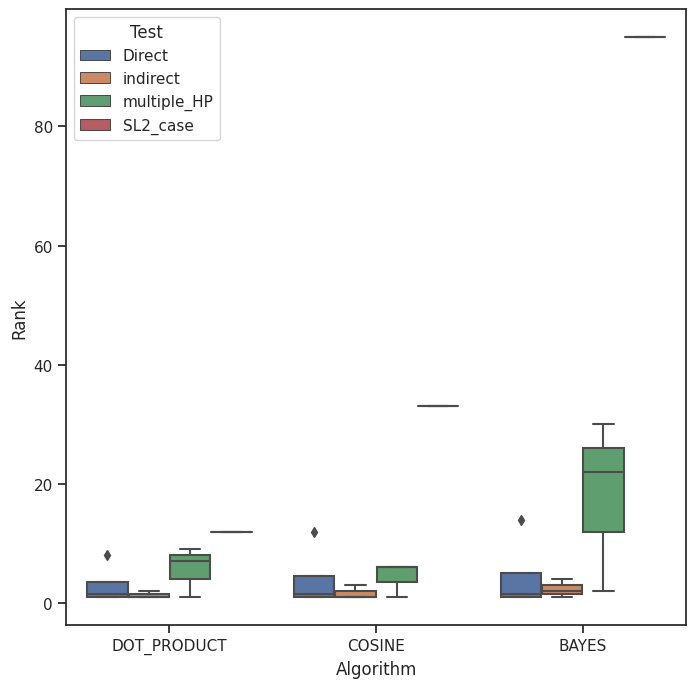

In [26]:
test_PCAN_melt_df = test_PCAN_sub_df.melt(id_vars=['test', 'Gene1', 'HPO'])
test_PCAN_melt_df.columns = ['Test', "Gene", "HPO", "Algorithm", "Rank"]
sns.set_theme(style="ticks")

test_PCAN_melt_df = test_PCAN_melt_df[test_PCAN_melt_df['Algorithm'] != 'Rank_bayes']

plt.figure(figsize=(8,8))
ax = sns.boxplot(y='Rank', x='Algorithm', data=test_PCAN_melt_df, hue='Test')

#ax = sns.swarmplot(y='value', x='variable', data=test_PCAN_melt_df, color="grey")


In [30]:
test_method_1_50_df = test_solved_df.head(50)
test_solved_50_100_df = test_solved_df.iloc[50:100].reset_index()
test_solved_100_150_df = test_solved_df.iloc[100:150].reset_index()
test_solved_150_200_df = test_solved_df.iloc[150:200].reset_index()
test_solved_200_250_df = test_solved_df.iloc[200:250].reset_index()
test_solved_250_267_df = test_solved_df.iloc[250:267].reset_index()


### using CKG probability

In [31]:
# Results with CKG IC

bayes_model = BayesRank(phenotype_new_df, gene_new_clinvar_df, probability_ckg_df)
dp_cosine_model = RankQuery(phenotype_new_df, gene_new_clinvar_df, probability_ckg_df, filter_gene_list)
bayes_clinvar_df = bayes_model.create_dataframe()
clinvar_test_1_50_df = run_methods(test_method_1_50_df, bayes_clinvar_df, dp_cosine_model, probability_ckg_df)
clinvar_test_50_100_df = run_methods(test_solved_50_100_df, bayes_clinvar_df, dp_cosine_model, probability_ckg_df)
clinvar_test_100_150_df = run_methods(test_solved_100_150_df, bayes_clinvar_df, dp_cosine_model, probability_ckg_df)
clinvar_test_150_200_df = run_methods(test_solved_150_200_df, bayes_clinvar_df, dp_cosine_model, probability_ckg_df)
clinvar_test_200_250_df = run_methods(test_solved_200_250_df, bayes_clinvar_df, dp_cosine_model, probability_ckg_df)
clinvar_test_250_267_df = run_methods(test_solved_250_267_df, bayes_clinvar_df, dp_cosine_model, probability_ckg_df)
df_clinvar_row_merged = pd.concat([clinvar_test_1_50_df, clinvar_test_50_100_df, 
                                   clinvar_test_100_150_df, clinvar_test_150_200_df,
                                   clinvar_test_200_250_df, clinvar_test_250_267_df], ignore_index=True)

df_clinvar_row_merged.to_csv("solved_cases_ranking.withCKGIC.clinvargenes.final.csv", index=False)

HPO HP:0012199 not found in the list of probabilities
HPO HP:0011113 not found in the list of probabilities
HPO HP:0012199 not found in the list of probabilities
HPO HP:0011113 not found in the list of probabilities
HPO HP:0012199 not found in the list of probabilities
HPO HP:0011113 not found in the list of probabilities
HPO HP:0012625 not found in the list of probabilities
HPO HP:0012625 not found in the list of probabilities
HPO HP:0012625 not found in the list of probabilities
HPO HP:0012625 not found in the list of probabilities
HPO HP:0012625 not found in the list of probabilities
HPO HP:0012625 not found in the list of probabilities
HPO HP:0011443 not found in the list of probabilities
HPO HP:0011443 not found in the list of probabilities
HPO HP:0011443 not found in the list of probabilities
HPO HP:0011443 not found in the list of probabilities
HPO HP:0011443 not found in the list of probabilities
HPO HP:0011443 not found in the list of probabilities
HPO HP:0003881 not found in 

KeyboardInterrupt: 

# Results with only Clinvar genes and PCAN probabilities

In [ ]:
bayes_model = BayesRank(phenotype_new_df, gene_new_clinvar_df, probability_table_PCAN_df)
dp_cosine_model = RankQuery(phenotype_new_df, gene_new_clinvar_df, probability_table_PCAN_df, filter_gene_list)
bayes_clinvar_df = bayes_model.create_dataframe()
clinvar_test_1_50_df = run_methods(test_method_1_50_df, bayes_clinvar_df, dp_cosine_model, probability_table_PCAN_df)
clinvar_test_50_100_df = run_methods(test_solved_50_100_df, bayes_clinvar_df, dp_cosine_model, probability_table_PCAN_df)
clinvar_test_100_150_df = run_methods(test_solved_100_150_df, bayes_clinvar_df, dp_cosine_model, probability_table_PCAN_df)
clinvar_test_150_200_df = run_methods(test_solved_150_200_df, bayes_clinvar_df, dp_cosine_model, probability_table_PCAN_df)
clinvar_test_200_250_df = run_methods(test_solved_200_250_df, bayes_clinvar_df, dp_cosine_model, probability_table_PCAN_df)
clinvar_test_250_267_df = run_methods(test_solved_250_267_df, bayes_clinvar_df, dp_cosine_model, probability_table_PCAN_df)
df_clinvar_row_merged = pd.concat([clinvar_test_1_50_df, clinvar_test_50_100_df, 
                                   clinvar_test_100_150_df, clinvar_test_150_200_df,
                                   clinvar_test_200_250_df,clinvar_test_250_267_df], ignore_index=True)
df_clinvar_row_merged.to_csv("solved_cases_ranking.withPCANIC.clinvargenes.final.csv", index=False)
#clinvar_test_1_50_df


In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
rank_threshold = [2,3,5,10,15,20,30,40,50,60,70,80,90,100,150,200,250,500,1000,2000,3000]
df_clinvar_PCAN_row_merged = pd.read_csv('solved_cases_ranking.withPCANIC.clinvargenes.final.csv')
df_clinvar_CKG_row_merged = pd.read_csv("solved_cases_ranking.withCKGIC.clinvargenes.final.csv")
Rank_HPO_CKG_CKG_df = compute_deltas(df_clinvar_CKG_row_merged, PCAN_df, "solved_cases_ranking.withCKGIC.clinvargenes.final.deltas.csv")
Rank_HPO_CKG_PCAN_df = compute_deltas(df_clinvar_PCAN_row_merged, PCAN_df, "solved_cases_ranking.withCKGIC.clinvargenes.final.deltas.csv")

change_names = {'Rank_dp': "DOT_PRODUCT", "Rank_cd": "COSINE", 'Rank_bayes_mean': "BAYES"}
Rank_HPO_CKG_CKG_df = Rank_HPO_CKG_CKG_df.rename(columns=change_names)
Rank_HPO_CKG_PCAN_df = Rank_HPO_CKG_PCAN_df.rename(columns=change_names)

In [ ]:
Rank_HPO_CKG_result_df = Rank_HPO_CKG_CKG_df[['Original ID', 'DOT_PRODUCT', 'COSINE', 'BAYES', 'Rank_PCAN' ]]
Rank_HPO_CKG_result_melt_df = Rank_HPO_CKG_result_df.melt(id_vars=['Original ID'])
Rank_HPO_CKG_result_melt_df.columns = ['Original_ID', 'method', 'Rank']
#test_rank =10
methods_list = ['DOT_PRODUCT', 'COSINE','BAYES', 'Rank_PCAN']
result_list = []
for j in rank_threshold:
    for i in methods_list:
        med_df = Rank_HPO_CKG_result_melt_df[Rank_HPO_CKG_result_melt_df['method'] == i]
        med_df['results'] = np.where(med_df.Rank < j, 1, 0)
        med_df['yact'] = 1
        recall = recall_score(med_df.yact.values, med_df.results.values)
        precision = precision_score(med_df.yact.values, med_df.results.values)
        out = [i, j, precision, recall]
        result_list.append(out)

sens_result_df = pd.DataFrame(result_list)
sens_result_df.columns = ['Method', 'Rank_Threshold', "Precision", "Cummulation Distribution Function"]
sns.lineplot(x = "Rank_Threshold", y = "Cummulation Distribution Function", data=sens_result_df, hue="Method")


In [ ]:
#plot_top
plot_bayes, bayes_counts = plot_top(Rank_HPO_CKG_result_df.Rank_bayes.values, "BAYES")
plot_dots, dots_counts = plot_top(Rank_HPO_CKG_result_df.Rank_dp.values, "DOT_PRODUCT")
plot_cosine, cosine_counts = plot_top(Rank_HPO_CKG_result_df.Rank_cd.values, "COSINE")
plot_bayes_mean, bayes_mean_counts = plot_top(Rank_HPO_CKG_result_df.Rank_bayes_mean.values, "BAYES MEAN")

In [ ]:
cosine_counts
bayes_counts_df = bayes_counts[['bins', 'Percentage', 'Algorithm']]
dp_counts_df = dots_counts[['bins', 'Percentage', 'Algorithm']] 
cosine_counts_df = cosine_counts[['bins', 'Percentage', 'Algorithm']] 
PCAN_count_df = PCAN_count[['bins', 'Percentage', 'Algorithm']] 
bayes_mean_counts_df = bayes_mean_counts[['bins', 'Percentage', 'Algorithm']] 

bayes_counts_df = bayes_counts_df.pivot(index="Algorithm", columns="bins", values="Percentage")
dp_counts_df = dp_counts_df.pivot(index="Algorithm", columns="bins", values="Percentage")
cosine_counts_df = cosine_counts_df.pivot(index="Algorithm", columns="bins", values="Percentage")
bayes_mean_count_df = bayes_mean_counts_df.pivot(index="Algorithm", columns="bins", values="Percentage")
PCAN_count_df = PCAN_count_df.pivot(index="Algorithm", columns="bins", values="Percentage")

stacked_df = pd.concat([bayes_counts_df, dp_counts_df, cosine_counts_df,bayes_mean_count_df, PCAN_count_df], axis=0)
stacked_df = stacked_df.reset_index()
order = ['Algorithm', 1, '2-5', '6-10','11-20', '21-30', '31-50', '51-100', '101-200','201-500', '>500', 'NA']
stacked_df = stacked_df.loc[:,order]

stacked_df = stacked_df[stacked_df['Algorithm'] != "BAYES"]
stacked_df = stacked_df.set_index('Algorithm')
ax = stacked_df.plot(kind='bar', 
                    stacked=True, 
                    colormap='inferno', 
                    figsize=(10, 6))
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.0f} %'.format(height), 
            horizontalalignment='center',
            verticalalignment='center')
    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
stacked_df

In [ ]:
Rank_HPO_CKG_PCAN_result_df = Rank_HPO_CKG_PCAN_df[['Original ID', 'DOT_PRODUCT', 'COSINE', 'BAYES', 'Rank_PCAN' ]]
Rank_HPO_CKG_PCAN_result_melt_df = Rank_HPO_CKG_PCAN_result_df.melt(id_vars=['Original ID'])
Rank_HPO_CKG_PCAN_result_melt_df.columns = ['Original_ID', 'method', 'Rank']
#test_rank =10
methods_list = ['DOT_PRODUCT', 'COSINE', 'BAYES', 'Rank_PCAN']
result_list = []
for j in rank_threshold:
    for i in methods_list:
        med_df = Rank_HPO_CKG_PCAN_result_melt_df[Rank_HPO_CKG_PCAN_result_melt_df['method'] == i]
        med_df['results'] = np.where(med_df.Rank < j, 1, 0)
        med_df['yact'] = 1
        recall = recall_score(med_df.yact.values, med_df.results.values)
        precision = precision_score(med_df.yact.values, med_df.results.values)
        out = [i, j, precision, recall]
        result_list.append(out)

sens_result_df = pd.DataFrame(result_list)
sens_result_df.columns = ['Method', 'Rank_Threshold', "Precision", "Cummulative Distribution Function"]
sns.lineplot(x = "Rank_Threshold", y = "Cummulative Distribution Function", data=sens_result_df, hue="Method")
sens_result_df

In [ ]:
#plot_top
plot_dots_PCAN, dots_counts_PCAN = plot_top(Rank_HPO_CKG_PCAN_df.Rank_dp.values, "DOT_PRODUCT")
plot_cosine_PCAN, cosine_counts_PCAN = plot_top(Rank_HPO_CKG_PCAN_df.Rank_cd.values, "COSINE")
plot_bayes_mean_PCAN, bayes_mean_counts_PCAN = plot_top(Rank_HPO_CKG_PCAN_df.Rank_bayes_mean.values, "BAYES MEAN")

In [ ]:
bayes_counts_PCAN_df = bayes_mean_counts_PCAN[['bins', 'Percentage', 'Algorithm']]
dp_counts_PCAN_df = dots_counts_PCAN[['bins', 'Percentage', 'Algorithm']] 
cosine_counts_PCAN_df = cosine_counts_PCAN[['bins', 'Percentage', 'Algorithm']] 
PCAN_count_df = PCAN_count[['bins', 'Percentage', 'Algorithm']] 


bayes_counts_PCAN_df = bayes_counts_PCAN_df.pivot(index="Algorithm", columns="bins", values="Percentage")
dp_counts_PCAN_df = dp_counts_PCAN_df.pivot(index="Algorithm", columns="bins", values="Percentage")
cosine_counts_PCAN_df = cosine_counts_PCAN_df.pivot(index="Algorithm", columns="bins", values="Percentage")
PCAN_count_df = PCAN_count_df.pivot(index="Algorithm", columns="bins", values="Percentage")

stacked_df = pd.concat([dp_counts_PCAN_df, cosine_counts_PCAN_df,bayes_counts_PCAN_df, PCAN_count_df], axis=0)
stacked_df = stacked_df.reset_index()
order = ['Algorithm', 1, '2-5', '6-10','11-20', '21-30', '31-50', '51-100', '101-200','201-500', '>500', 'NA']
stacked_df = stacked_df.loc[:,order]

stacked_df = stacked_df[stacked_df['Algorithm'] != "BAYES"]
stacked_df = stacked_df.set_index('Algorithm')
ax = stacked_df.plot(kind='bar', 
                    stacked=True, 
                    colormap='inferno', 
                    figsize=(10, 6))
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.0f} %'.format(height), 
            horizontalalignment='center',
            verticalalignment='center')
    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
stacked_df

## Results with only Clinvar genes and Mayo probabilities

In [ ]:
#bayes_model = BayesRank(phenotype_new_df, gene_new_clinvar_df, probability_table_mayo_df)
#dp_cosine_model = RankQuery(phenotype_new_df, gene_new_clinvar_df, probability_table_mayo_df, filter_gene_list)
#bayes_clinvar_mayo_df = bayes_model.create_dataframe()
#clinvar_mayo_1_50_df = run_methods(test_method_1_50_df, bayes_clinvar_mayo_df, dp_cosine_model,
#                                   probability_table_mayo_df)
#clinvar_mayo_50_100_df = run_methods(test_solved_50_100_df, bayes_clinvar_mayo_df, dp_cosine_model,
#                                    probability_table_mayo_df)
#clinvar_mayo_100_150_df = run_methods(test_solved_100_150_df, bayes_clinvar_mayo_df, dp_cosine_model,
#                                     probability_table_mayo_df)
#clinvar_mayo_150_200_df = run_methods(test_solved_150_200_df, bayes_clinvar_mayo_df, dp_cosine_model,
#                                     probability_table_mayo_df)
#clinvar_mayo_200_250_df = run_methods(test_solved_200_250_df, bayes_clinvar_mayo_df, dp_cosine_model,
#                                     probability_table_mayo_df)
#df_clinvar_mayo_row_merged = pd.concat([clinvar_mayo_1_50_df, clinvar_mayo_50_100_df, 
#                                   clinvar_mayo_100_150_df, clinvar_mayo_150_200_df,
#                                   clinvar_mayo_200_250_df], ignore_index=True)
#df_clinvar_mayo_row_merged.to_csv("solved_cases_ranking.withMayoIC.clinvargenes.csv", index=False)

### PLOTS with MAYO IC and PCAN IC Subsetted to Clinvar genes

In [ ]:
plot_pt_dot_single(Rank_HPO_CKG_CKG_df,"delta_bayes_geo_PCAN")
plot_pt_dot_pair(Rank_HPO_CKG_CKG_df,"delta_bayes_geo_PCAN", 'delta_bayes_PCAN')
plot_pt_dot_single(Rank_HPO_CKG_CKG_df,"rank_bayes_geo")
plot_pt_dot_single(Rank_HPO_CKG_CKG_df,"Rank_bayes_mean")

# Results with All genes and PCAN probabilities

In [ ]:
#bayes_all_model = BayesRank(phenotype_new_df, gene_new_df, probability_table_PCAN_df)
#dp_cosine_all_model = RankQuery(phenotype_new_df, gene_new_df, probability_table_PCAN_df, filter_gene_list)
#bayes_clinvar_all_df = bayes_all_model.create_dataframe()
#all_test_1_50_df = run_methods(test_method_1_50_df, bayes_clinvar_all_df, dp_cosine_all_model)
#all_test_50_100_df = run_methods(test_solved_50_100_df, bayes_clinvar_all_df, dp_cosine_all_model)
#all_test_100_150_df = run_methods(test_solved_100_150_df, bayes_clinvar_all_df, dp_cosine_all_model)
#all_test_150_200_df = run_methods(test_solved_150_200_df, bayes_clinvar_all_df, dp_cosine_all_model)
#all_test_200_250_df = run_methods(test_solved_200_250_df, bayes_clinvar_all_df, dp_cosine_all_model)
#df_clinvar_PCAN_all_merged = pd.concat([all_test_1_50_df, all_test_50_100_df, 
#                                   all_test_100_150_df, all_test_150_200_df,
#                                   all_test_200_250_df], ignore_index=True)
#df_clinvar_PCAN_all_merged.to_csv("solved_cases_ranking.withPCANIC.ALLgenes.csv", index=False)


In [ ]:
#bayes_all_model = BayesRank(phenotype_new_df, gene_new_df, probability_table_mayo_df)
#dp_cosine_all_model = RankQuery(phenotype_new_df, gene_new_df, probability_table_mayo_df, filter_gene_list)
#bayes_all_df = bayes_all_model.create_dataframe()
#mayo_all_test_1_50_df = run_methods(test_method_1_50_df, bayes_clinvar_all_df, dp_cosine_all_model)
#mayo_all_test_50_100_df = run_methods(test_solved_50_100_df, bayes_all_df, dp_cosine_all_model)
#mayo_all_test_100_150_df = run_methods(test_solved_100_150_df, bayes_all_df, dp_cosine_all_model)
#mayo_all_test_150_200_df = run_methods(test_solved_150_200_df, bayes_all_df, dp_cosine_all_model)
#mayo_all_test_200_250_df = run_methods(test_solved_200_250_df, bayes_all_df, dp_cosine_all_model)
#df_mayo_all_merged = pd.concat([mayo_all_test_1_50_df, mayo_all_test_50_100_df, 
#                                   mayo_all_test_100_150_df, mayo_all_test_150_200_df,
#                                   mayo_all_test_200_250_df], ignore_index=True)
#df_mayo_all_merged.to_csv("solved_cases_ranking.withmayoIC.ALLgenes.csv", index=False)


In [ ]:
## generate PR curves

